## Integrantes:
1. Camila Coltriani
2. Luis Dartayet
3. Irania Fuentes
4. Jonathan Fichelson
5. Ornella Cevoli
# Trabajo práctico  4: Analisis de los sentimientos en Twitter

# Introducción
Las redes sociales como Twitter han demostrado ser excelentes recursos de información sobre muchos eventos que acontecen en el mundo; tienen el poder de cambiar las opiniones de millones de personas siendo especialmente útil para influir en las masas: campañas políticas, cotización de monedas virtuales, publicidad de ventas, entre otros.
Pensando en esto, se presenta el siguiente objetivo.

# Objetivo:
Analizar los sentimientos con la finalidad de predecir el comportamiento de personas y propagar cambios en tiempo real a medida que se desarrolla el evento que se quiere estudiar.

## Fuente:
Dataset Kaggle: https://www.kaggle.com/code/paoloripamonti/twitter-sentiment-analysis/input

## 1. Importación de Librerias

In [33]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import pickle

import re
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## 2. Importación de los datos

In [34]:
#cargar y leer el dataset
data = pd.read_csv('./data/twitter.csv', encoding='ANSI')
data.columns = [ 'target', 'id', 'date', 'flag', 'user', 'text']
print(data.shape)
data.head()

(1599999, 6)


,target,id,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Detalle de Dataset

**target*: Indica la polaridad del tweet (0 = negativo, 2 = neutral, 4 = positivo)

**ids*: el #id del tweet

**date*: el día del tweet 

**flag*: consulta. cuando esta vacio el valor es NO_QUERY.

**user*: el nombre del usuario que realizó eltweet

**text*: el texto del tweet


## 3. Análisis exploratorio de los datos

In [35]:
# Check nulls and duplicates
print('Nulls: ', data.isnull().sum())
print('Duplicates: ', data.duplicated().sum())

Nulls:  target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64
Duplicates:  0


In [36]:
# Remove useless columns
data.drop(['id', 'date', 'flag', 'user'], axis=1, inplace=True)

In [37]:
# Rename target
data['target'] = data['target'].map({0: 'negative', 4: 'positive'})

In [38]:
# Check target distribution
print('Target distribution: ', data.target.value_counts())

Target distribution:  positive    800000
negative    799999
Name: target, dtype: int64


In [39]:
#Asignamos las variables X e Y a modelar
X = data.text
y = data.target

## 3. Preprocesamiento de los datos

### 3.1 División del dataset en train y test

In [40]:
#Dividimos en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1119999,)
(480000,)
(1119999,)
(480000,)


### 3.2 Limpieza del corpus: definición de una función para eliminar Stopword, aplicación de Stemming, convertir a minisculas

In [41]:
# Expresion regular para eliminar del corpus signos de puntación/ @/ direcciones electronicas/ numeros
limpieza_re = "\d+[^0-9]|@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]"

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

#Funcion para limpiar el corpus
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(limpieza_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)


In [42]:
#Definición de la clase de procesamiento de texto
class TextProcessing(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.apply(preprocess)

## 4. Configuración del pipeline y modelos a utilizar para la predicción de los sentimientos

In [44]:
common_steps = [
            ('text_processing', TextProcessing()),
            ('vectorizer', CountVectorizer()),
            ]

In [45]:
# Modelos a utilizar

LR_pipe = [Pipeline( common_steps + [('lr', LogisticRegression())]), {'lr__C':[0.01,0.1,1], 'lr__penalty':['l2']}]
DT_pipe = [Pipeline( common_steps + [('dt', tree.DecisionTreeClassifier())]), {'dt__max_depth':[ 8, 12, 16] }]
MNB_pipe = [Pipeline( common_steps + [('mnb', MultinomialNB())]), {'mnb__alpha':[1, 10, 20]}]

skf=StratifiedKFold(n_splits=3,random_state=0,shuffle=True)
models = []


In [46]:
#Configuración del gridsearch para el modelo de Regresión Logistica y definir los mejores parametros 
pipelines = [ LR_pipe]

for pipe in pipelines:
    GS_CV=GridSearchCV(pipe[0],pipe[1],cv=skf,verbose=10,n_jobs=3);
    GS_CV.fit(X_train, y_train);
    models.append(GS_CV)
    print('best score:',GS_CV.best_score_)
    print('best params:',GS_CV.best_params_) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
best score: 0.7749962276752033
best params: {'lr__C': 0.1, 'lr__penalty': 'l2'}


c:\Users\ornel\anaconda3\envs\DH\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
#Configuración del gridsearch para el modelo de arbol de decisión y definir los mejores parametros 
pipelines = [ DT_pipe]

for pipe in pipelines:
    GS_CV=GridSearchCV(pipe[0],pipe[1],cv=skf,verbose=10,n_jobs=3);
    GS_CV.fit(X_train, y_train);
    models.append(GS_CV)
    print('best score:',GS_CV.best_score_)
    print('best params:',GS_CV.best_params_) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
best score: 0.5999916071353635
best params: {'dt__max_depth': 16}


In [48]:
#Configuración del gridsearch para el modelo de Multinomial Naive Baye y definir los mejores parametros 
pipelines = [ MNB_pipe]

for pipe in pipelines:
    GS_CV=GridSearchCV(pipe[0],pipe[1],cv=skf,verbose=10,n_jobs=3);
    GS_CV.fit(X_train, y_train);
    models.append(GS_CV)
    print('best score:',GS_CV.best_score_)
    print('best params:',GS_CV.best_params_) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
best score: 0.7659738981909805
best params: {'mnb__alpha': 10}


In [49]:
## Models evaluation

for model in models:
    print(model.best_estimator_)
    y_pred = model.predict(X_test)
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Classification report: ', classification_report(y_test, y_pred))
    print('Confusion matrix: ', confusion_matrix(y_test, y_pred))



Pipeline(steps=[('text_processing', TextProcessing()),
                ('vectorizer', CountVectorizer()),
                ('lr', LogisticRegression(C=0.1))])
Accuracy:  0.77784375
Classification report:                precision    recall  f1-score   support

    negative       0.79      0.75      0.77    240000
    positive       0.76      0.81      0.78    240000

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000

Confusion matrix:  [[179813  60187]
 [ 46448 193552]]
Pipeline(steps=[('text_processing', TextProcessing()),
                ('vectorizer', CountVectorizer()),
                ('dt', DecisionTreeClassifier(max_depth=16))])
Accuracy:  0.6002520833333334
Classification report:                precision    recall  f1-score   support

    negative       0.81      0.26      0.40    240000
    positive       0.56      0.94      0.70    240000

    accuracy                

In [50]:
# pick best model
best_model = models[0]
for model in models:
    if model.best_score_ > best_model.best_score_:
        best_model = model
        

In [51]:
# Predict new data
new_data = ['supercalifragilisticexpialidocious']

new_data = pd.Series(new_data)
new_data = new_data.apply(preprocess)

best_model.predict(new_data)



array(['positive'], dtype=object)

c:\Users\ornel\anaconda3\envs\DH\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


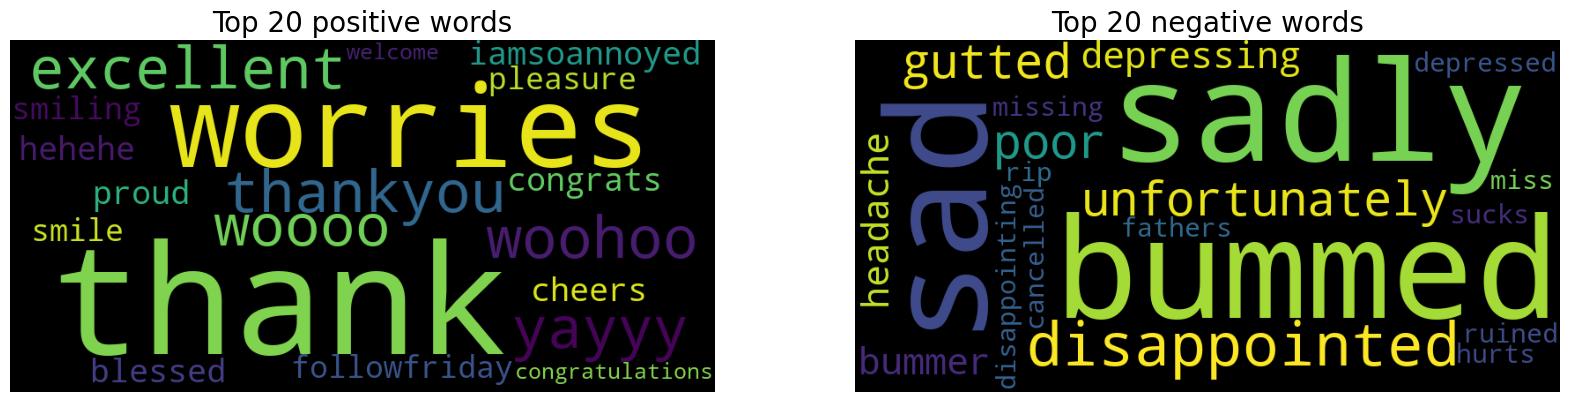

In [52]:
# Wordcloud

# Get the best model
model = best_model.best_estimator_

# Get the vectorizer
vectorizer = model.named_steps['vectorizer']

# Get the feature names
feature_names = vectorizer.get_feature_names()

# Get the coefficients
coef = model.named_steps['lr'].coef_[0]

# Get the top 20 positive and negative words
top_positive_words = [feature_names[i] for i in coef.argsort()[-20:]]
top_negative_words = [feature_names[i] for i in coef.argsort()[:20]]

# Create the wordclouds
wordcloud_pos = WordCloud(width=800, height=400).generate(" ".join(top_positive_words))
wordcloud_neg = WordCloud(width=800, height=400).generate(" ".join(top_negative_words))

# Plot the wordclouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(wordcloud_pos)
ax1.axis("off")
ax1.set_title("Top 20 positive words", fontsize=20)
ax2.imshow(wordcloud_neg)
ax2.axis("off")
ax2.set_title("Top 20 negative words", fontsize=20)
plt.show()

In [53]:
# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)


In [54]:
# open model
savedModel = None
with open('model.pkl', 'rb') as f:
    savedModel = pickle.load(f)

In [55]:
# check model
savedModel.predict(new_data)
 

array(['positive'], dtype=object)

In [56]:
from flask import Flask, render_template, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    text = request.form['text']
    text = pd.Series(text)
    text = text.apply(preprocess)
    sentiment = best_model.predict(text)
    return render_template('result.html', sentiment=sentiment)

# Define the index route
@app.route('/')
def index():
    return render_template('index.html')

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
